In [5]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np


# Introduction


This document is the guideline to the PRACTICE #2. The goals of this practice are:

  1. Test different evaluation methods over probabilistic and classification models.
  2. Experiment with model selection, namely by applying cross-validation, as main technique.
  
We'll use the Titanic dataset, that has been polished and simplified for you. You can download the dataset from Kaggle: https://www.kaggle.com/c/titanic.

This one has been widely used in many competitions, so it will easy to find solutions if you get stuck with it. Good luck!

# Data Loading and Preparing

Our sample dataset: passengers of the RMS Titanic. We will use an open data set with data on the passengers aboard the infamous doomed sea voyage of 1912. We will experiment with logistic regression to predict whether a given passenger would have survived this disaster. The file containing the dataset is `titanic.csv` and should be read using the simple command: 

In [6]:
# Note that you should modify the filepath according to where you have them

df = pd.read_csv("data/titanic.csv", sep=";")
df.dtypes

pclass      float64
survived    float64
sex          object
age          object
sibsp       float64
parch       float64
ticket       object
fare         object
cabin        object
embarked     object
dtype: object

Some formats are not correct, let's fix that

In [7]:
df['sex'].replace(['female','male'],[0,1],inplace=True)
df['embarked'].replace(['Q','S', 'C'],[0,1,2],inplace=True)
df['age'] = df.age.apply(lambda x: str(x).replace(',','.')).astype('float64') # The numbers include commas instead of dots (26,4 instead of 26.4). We have to change it to allow its conversion to float
df['fare'] = df.fare.apply(lambda x: str(x).replace(',','.')).astype('float64') # The nummbers include commas instead of dots (26,4 instead of 26.4). We have to change it to allow its conversion to float

df.dtypes

pclass      float64
survived    float64
sex         float64
age         float64
sibsp       float64
parch       float64
ticket       object
fare        float64
cabin        object
embarked    float64
dtype: object

The column heading variables have the following meanings:

  * survival: Survival (0 = no; 1 = yes)
  * pclass: Passenger class (1 = first; 2 = second; 3 = third)
  * name: Name
  * sex: Sex
  * age: Age
  * sibsp: Number of siblings/spouses aboard
  * parch: Number of parents/children aboard
  * ticket: Ticket number
  * fare: Passenger fare
  * cabin: Cabin
  * embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
  
Your first decision will be whether data needs to standardized or not, and what are the relevant features for this model. My only advice is not to use `cabin` nor `ticket`.

In [8]:
del df['cabin']
del df['ticket']

If we take a look at the dataset, we will see that we have some null values that we have to take care of

In [9]:
df.isnull().sum()

pclass        1
survived      1
sex           1
age         264
sibsp         1
parch         1
fare          2
embarked      3
dtype: int64

We will impute the missing age values by using the mean of the column

In [10]:
print(df["age"].mean())
df['age'] = df['age'].replace(np.nan, df["age"].mean())
df.isnull().sum()

29.8811345124283


pclass      1
survived    1
sex         1
age         0
sibsp       1
parch       1
fare        2
embarked    3
dtype: int64

We will just remove the rest of them for the sake of simplicity

In [11]:
df.dropna(inplace=True)
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

We will now split the dataset in train and test

As we are going to split the dataset several times in this practice, I have created the following function to take care of it.

This function takes the original dataset, prepare the dataset and split it into train and test by using the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) in sklearn. As you can read in the documentation of this function, the splitting is done randomly unless you set a seed (via the `random_state` parameter). This is something to be considered in your experimentation. If you care for reproducibility, you have to set this random_state, otherwise you will get a different splitting every time.

In [37]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = dataframe.loc[:, dataframe.columns != 'survived']
    y = dataframe['survived']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)


Check how by setting the random seed to a constant, we always get the same splitting

In [60]:
X_train, X_test, y_train, y_test = split_df(df, seed=100)

In [56]:
#Test performance with different data % splits by creating a dictionary and evaluating values with 5% splits of data
performance = {}

for i in range(60,100,4):
    i = i/100
    X_train, X_test, y_train, y_test = split_df(df, seed=100, percentage=i)
    performance[i]=[{"X_train":X_train, "X_test":X_test,"y_train":y_train,"y_test":y_test  }]
    


# Modeling

Our task is to predict if passenger survived or not. The simplest decision will be to use Logistic Regression. You must have already decided what are the relevant fields to use.

The following code cells give you an idea on how to run the logistic regression, compute the true positive rate, false positive rate and a cost function associated with false positives and false negatives. 

In [65]:
from sklearn import linear_model

model = linear_model.LogisticRegression(max_iter=100, solver='liblinear')
model.fit(X_train, y_train)

# The predicted probabilities given to each sample in the test set. `predict_proba` gives you the probabilities of both classes, we take the probs of class 1 for simplicity.
probs = model.predict_proba(X_test)[:,1]

# The predictions in the form of a dataset to make manipulation easier. We put together here the actual 'labels' and the predicted 'probabilities'.
predictions = pd.DataFrame({'survived':y_test, 'pred':probs})
predictions.head()

,survived,pred
979,0.0,0.077033
401,1.0,0.794494
741,0.0,0.208219
1144,0.0,0.059930
866,1.0,0.755900


Our model gave us the probability of survival. However, our task was to predict the binary value survived or not. Therefore, we have to decide which threshold we use, such as if the probability of survival is larger than the threshold, we will predict that the passenger survived.

Let's experiment with this threshold and check how it affects the model performance

## The ROC Curve

As explained in class, the ROC Curve is a great tool to inspect the overall model performance according to different threshold values. To better understand how it works, let's compute how model performs for a specific threshold to then extend the analysis to different thresholds.

A first sensible value to try is 0.5. If the probability of survival, as predicted by our model, is larger than 50%, we will assume that the passenger survived. The following figure shows the resulting confusion matrix for this threshold

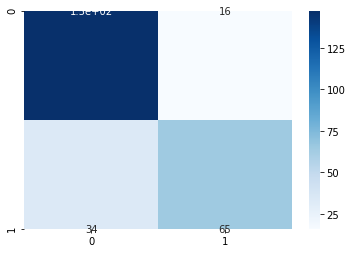

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

threshold = 0.5

cm = confusion_matrix(predictions.survived, [pred>threshold for pred in predictions.pred])
sn.heatmap(cm, annot=True, cmap=plt.cm.Blues);


Not bad.

The ROC is based on two metrics that we can extract from the Confusion Matrix: True Positive Rate and False Positive Rate

Function to calculate the True positive rate.

In [16]:
def tpr(predictions, threshold):
    cm = confusion_matrix(predictions.survived, [pred>threshold for pred in predictions.pred])
    return cm[1,1]/sum(cm[1,:])

In [17]:
print("TPR = {}".format(tpr(predictions, threshold)))

TPR = 0.6565656565656566


Function to calculate the False positive rate.

In [18]:
def fpr(predictions, threshold):
    cm = confusion_matrix(predictions.survived, [pred>threshold for pred in predictions.pred])
    return cm[0,1]/sum(cm[0,:])

In [19]:
print("FPR = {}".format(fpr(predictions, threshold)))

FPR = 0.09815950920245399


Function to calculate the Cost for false positives and false negatives. You can play with the cost function to penalize whatever is more important in your business case.

In [20]:
def cost(predictions, threshold, fp_cost = 1, fn_cost=2):
    cm = confusion_matrix(predictions.survived, [pred>threshold for pred in predictions.pred])
    return cm[0,1] * fp_cost + cm[1,0] * fn_cost

In [21]:
print("Cost = {}".format(cost(predictions, threshold)))

Cost = 84


What we see as a result is the first raw conclusion without knowing if 0.5 is a good threshold. You can try different threshold values by changing the `threshold` value.

### Build the ROC

A better way to understand the model performance for each threshold value as well as to understand the overall performance of the model is to create the ROC. sklearn provides a handy way of computing the TPR, FPR as well as of creating the ROC and computing the Area Under the Curve.

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(predictions.survived, predictions.pred)

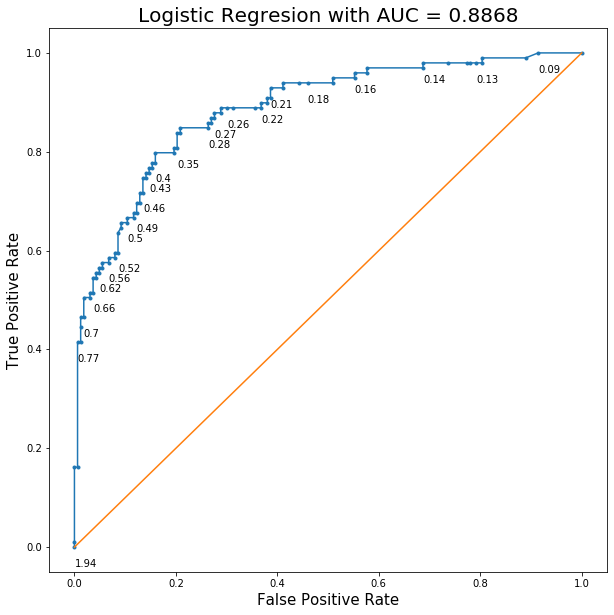

In [23]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, marker='.')
for x, y, txt in zip(fpr[::4], tpr[::4], thresholds[::4]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
# axis labels
plt.title('Logistic Regresion with AUC = {0:.4f}'.format(roc_auc_score(predictions.survived, predictions.pred)), fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# show the plot
plt.show()



## Double Density Plot

In class I mentioned the Double Density Plot, an alternative to the ROC. There is no function to print this plot in sklearn, but you can easily do it with some Python coding

In [24]:
from importlib import reload 
reload(plt);

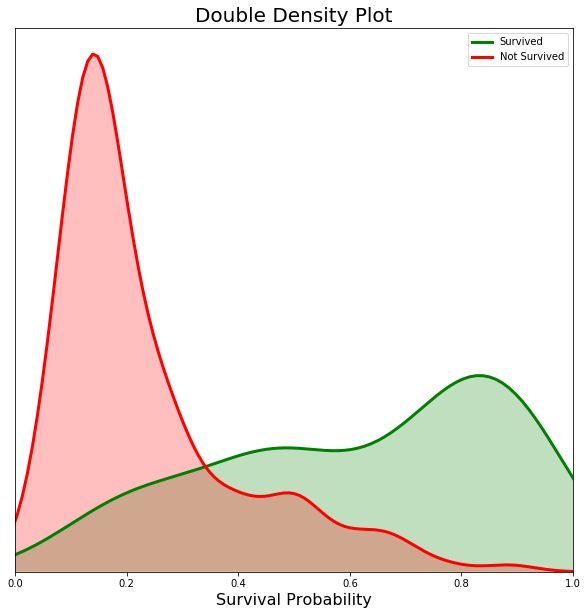

In [25]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.yticks([])
plt.xlim((0, 1)) 
plt.xlabel("Survival Probability", fontsize=16)
plt.title("Double Density Plot", fontsize=20)
sns.distplot([p for label, p in predictions.values if label == 1.0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3, 'kernel': 'gau'}, label = "Survived", color='Green')
sns.distplot([p for label, p in predictions.values if label == 0.0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3, 'kernel': 'gau'}, label = "Not Survived", color='Red');

# Practice Goals

Now you know how what features are relevant to your model, and how to measure your model's performance. But we can improve this a bit. Go through the steps below:

  1. We have measured our model's performance against a single test-set. We're sure our model is the best possible model against that test-set, but we want to be sure, that is the best against any possible test set. To do that, please, measure how your model results change when using different test sets. To do that, simply start over the process at least 10 times with different splits of the full dataset into training and test. Result might differ, so illustrate that difference in performance. **(FUNDAMENTAL)**
  2. Following with the approach of the previous step, let's go one step further, and apply cross-validation. This is, train your model against 60% of the data. Use another 20% cross-validation set to select the best possible threshold, and finally, measure the performance of that threshold selection against the remaining 20% test set (yet unseen to the model). **(FUNDAMENTAL)**
  
Good luck!